In [150]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from utilsMinihackSearch import *
import operator

In [151]:
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file = "complex_maze.des",
)
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                   -----------------                            
                     ----------    |...............|                            
                     |........|    |............|..|                            
                     |........|    |............|..|                            
                     ------...|    |..-----..----..|                            
                          |...|    |..|   |........|                            
                          |...|    |..|   |........|  ------                    
                    -------...------..|   |.....----  |....|                    
                    |.................|   |.....|     |....|                    
                    |..-----....|..|..|   |.....-------....|                    
                    |..|   

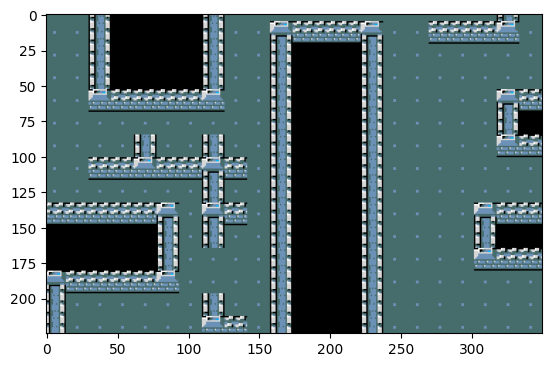

In [152]:
plt.imshow(state['pixel'][75:300, 450:800])

In [153]:
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)
print("Agent position:", start)
print("Target position:", target)

Agent position: (14, 23)
Target position: (14, 57)


In [154]:
import random
import time


def initialize_states(game_map: np.ndarray, start: Tuple[int, int], k: int):

    init_states = [list(random.choice(get_valid_moves(game_map, start))) for _ in range(k)]
    
    current_states = []
    for state in init_states:
        current_states.append({
            'current': tuple(state),
            'explored_nodes': [tuple(state)],
            'path': [tuple(state)]
        })

    return current_states

def get_successors_from_states(game_map: np.ndarray, states: list):

    state_neighbors = []

    for state in states:
        neighbors = get_valid_moves(game_map, state['current'])
        state_neighbors.append({
            'path': state['path'],
            'explored_nodes': state['explored_nodes'],
            'possible_moves': neighbors
        })
        

    return state_neighbors

def get_heuristic_scores(heuristic: callable, neighbors: list):

    scored_moves = []

    for state in neighbors:
        for move in state['possible_moves']:
            score = heuristic(move, target)
            scored_moves.append({
                'path': state['path'],
                'explored_nodes': state['explored_nodes'],
                'current': move,
                'distance': score,
            })
    
    return scored_moves

def assign_probabilities(sorted_array):
    n = len(sorted_array)
    probabilities = [1 / (i + 1) for i in range(n)]
    
    # give the same probability if two elements has the same distance
    for i in range(1, n):
        if sorted_array[i] == sorted_array[i - 1]:
            probabilities[i] = probabilities[i - 1]
    
    return probabilities

def get_next_states(scored_successors: list, k: int, stocastic: bool):

    scored_successors = sorted(scored_successors, key = lambda x: x['distance'])
    top = []

    if stocastic:
        cont = 0
        while cont < k:
            # top.append(scored_successors[random.randrange(0, len(scored_successors))])
            probability_array = assign_probabilities(scored_successors)
            choice = random.choices(scored_successors, probability_array)[0]
            if choice not in top:
                top.append(choice)
                cont += 1
    else:
        cont = 0
        for succ in scored_successors:
            if cont < k:
                if succ['current'] not in succ['explored_nodes']:
                    # print('Before', succ['explored_nodes'], succ['distance'])
                    succ['explored_nodes'] = succ['explored_nodes'] + [succ['current']]
                    # print('After', succ['explored_nodes'], succ['distance'])
                    top.append(succ)
                    cont += 1

                
    
    next_states = list()
    
    for s in top:
        next_states.append({
            'current': s['current'],
            'explored_nodes': s['explored_nodes'],
            'path': s['path'] + [s['current']]
        })
    print(next_states)
    return next_states


def local_beam_search(game_map: np.ndarray, start: Tuple[int, int], target: Tuple[int, int], heuristic: callable, k: int = 3, max_iter: int = 100, stocastic: bool = False):

    current_states = initialize_states(game_map, start, k)

    for i in range(max_iter):

        state_neighbors = get_successors_from_states(game_map, current_states)

        if len(current_states) == 0 or i == max_iter - 1:
            print("Path not found!")
            path = [start] + backup_states[0]['path'] + [move]
            return path
        
        # check if a possible move is the target
        for state in state_neighbors:
            for move in state['possible_moves']:
                if move == target:
                   print('Path found!')
                   path = [start] + state['path'] + [move]
                   return path

        scored_successors = get_heuristic_scores(heuristic, state_neighbors)
        backup_states = current_states
        current_states = get_next_states(scored_successors, k, stocastic)

    


path = local_beam_search(game_map, get_player_location(game_map), get_target_location(game_map), manhattan_distance, stocastic=False, max_iter=1000)
path

[{'current': (15, 24), 'explored_nodes': [(15, 23), (15, 24)], 'path': [(15, 23), (15, 24)]}, {'current': (14, 23), 'explored_nodes': [(15, 23), (14, 23)], 'path': [(15, 23), (14, 23)]}, {'current': (14, 23), 'explored_nodes': [(13, 23), (14, 23)], 'path': [(13, 23), (14, 23)]}]
[{'current': (14, 24), 'explored_nodes': [(15, 23), (15, 24), (14, 24)], 'path': [(15, 23), (15, 24), (14, 24)]}, {'current': (14, 24), 'explored_nodes': [(15, 23), (14, 23), (14, 24)], 'path': [(15, 23), (14, 23), (14, 24)]}, {'current': (14, 24), 'explored_nodes': [(13, 23), (14, 23), (14, 24)], 'path': [(13, 23), (14, 23), (14, 24)]}]
[{'current': (14, 23), 'explored_nodes': [(15, 23), (15, 24), (14, 24), (14, 23)], 'path': [(15, 23), (15, 24), (14, 24), (14, 23)]}, {'current': (13, 24), 'explored_nodes': [(15, 23), (15, 24), (14, 24), (13, 24)], 'path': [(15, 23), (15, 24), (14, 24), (13, 24)]}, {'current': (15, 24), 'explored_nodes': [(15, 23), (14, 23), (14, 24), (15, 24)], 'path': [(15, 23), (14, 23), (1

[(14, 23),
 (15, 23),
 (15, 24),
 (14, 24),
 (13, 24),
 (13, 23),
 (14, 23),
 (14, 22),
 (15, 22),
 (15, 21),
 (14, 21),
 (13, 21),
 (13, 22),
 (12, 22),
 (12, 21),
 (11, 21),
 (11, 22),
 (10, 22),
 (9, 22),
 (9, 23),
 (9, 24),
 (9, 25),
 (9, 26),
 (9, 27),
 (9, 28),
 (10, 28),
 (11, 28),
 (12, 28),
 (12, 29),
 (12, 30),
 (12, 31),
 (12, 32),
 (12, 33),
 (12, 34),
 (13, 34),
 (14, 34),
 (15, 34),
 (15, 35),
 (15, 36),
 (14, 36),
 (14, 37),
 (15, 37),
 (16, 37),
 (16, 36),
 (17, 36),
 (17, 37),
 (18, 37),
 (19, 37),
 (19, 36),
 (19, 35),
 (19, 34),
 (18, 34),
 (17, 34),
 (17, 33),
 (17, 32),
 (17, 31),
 (17, 30),
 (18, 30),
 (18, 31),
 (18, 32),
 (18, 33),
 (19, 33),
 (19, 32),
 (19, 31),
 (19, 30),
 (19, 29),
 (18, 29),
 (17, 29),
 (18, 29)]

In [155]:
actions = actions_from_path(start, path[1:])

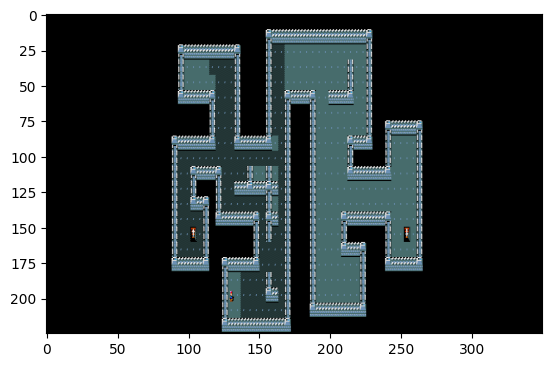

In [156]:
image = plt.imshow(state['pixel'][75:300, 450:800])
for action in actions:
    s, _, _, _ = env.step(action)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    image.set_data(s['pixel'])